In [3]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
#import torch.selfim as selfim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

%matplotlib inline

#import pytorch-fid
import time
import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms, models
import torchvision.transforms as T
from torch.autograd import Variable
import os 
import sys
from PIL import Image

In [73]:
class Parameters:
    def __init__(self):

        self.batchSize = 64
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        self.niter = 1
        self.lr = 0.0002
        self.beta1 = 0.5
        self.cuda = True
        self.ngpu = 1
        self.manual_seed = 0
        self.imageSize = 64
        self.outf = os.path.join(sys.path[0], "model_data")
        self.netG = ''
        self.netD = ''

params = Parameters()

#latent vector size
params.nz = 100

#size of feature maps
params.ngf = 64
params.ndf = 64

params.cuda = True
params.ngpu = 1
params.imageSize = 64

#batch size
params.batchSize = 64

#epochs
params.niter = 100

#learning rate
params.lr = 0.0002

#beta optimizer for Adam optimizers
params.beta1 = 0.5

#Change this string out for a saved pytorch state dict, if you want to load model from saved training state.
params.netG = os.path.join(sys.path[0], "model_data/generator_dicts/netG_epoch_199.pth")
params.netD = os.path.join(sys.path[0], "model_data/discriminator_dicts/netD_epoch_199.pth")

#number of channels (related to color)
nc = 1

In [67]:
def load_data(batch_size: int = 128):
    """
    Load dataset.
    :return: DataLoader object
    """

    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    } if torch.cuda.is_available() else {}

    # format image data, but do not normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.Resize(params.imageSize),
         transforms.ToTensor()
        ])
    path = "image_data/cleaned_train"
    dataset = datasets.ImageFolder(path,transform)
    # load data
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        **cuda_kwargs
    )
    return loader

In [69]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [70]:
ngpu = int(params.ngpu)
nz = int(params.nz)
ngf = int(params.ngf)
ndf = int(params.ndf)

params.manualSeed = random.randint(1, 10000)
random.seed(params.manualSeed)
torch.manual_seed(params.manualSeed)
cudnn.benchmark = True
dataloader = load_data(batch_size= params.batchSize)
if params.cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if params.netG != '':
    netG.load_state_dict(torch.load(params.netG))
print(netG)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if params.netD != '':
    netD.load_state_dict(torch.load(params.netD))
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [74]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(params.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
epoch_counter = 0

loss_D_arr = []
loss_G_arr = []
for epoch in range(params.niter):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                           dtype=real_cpu.dtype, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, params.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        loss_D_arr.append(errD.item())
        loss_G_arr.append(errG.item())
        
    
    if epoch_counter % 20 == 0:
        vutils.save_image(real_cpu,
                '%s/real_images/real_images.png' % params.outf,
                normalize=True)
        fake = netG(fixed_noise)
        vutils.save_image(fake.detach(),
                '%s/generated_images/fake_images_epoch_%03d.png' % (params.outf, epoch),
                normalize=True)
            # do checkpointing
    if epoch_counter % 50 == 0:
        torch.save(netG.state_dict(), '%s/generator_dicts/netG_epoch_%d.pth' % (params.outf, epoch))
        torch.save(netD.state_dict(), '%s/discriminator_dicts/netD_epoch_%d.pth' % (params.outf, epoch))
    epoch_counter += 1

np.save("loss_D_arr", loss_D_arr, allow_pickle= True)
np.save("loss_G_arr", loss_G_arr, allow_pickle= True)

[0/100][0/82] Loss_D: 0.0355 Loss_G: 12.6250 D(x): 0.9995 D(G(z)): 0.0328 / 0.0001
[0/100][1/82] Loss_D: 0.2209 Loss_G: 6.1000 D(x): 0.8561 D(G(z)): 0.0008 / 0.0542
[0/100][2/82] Loss_D: 0.1830 Loss_G: 10.4738 D(x): 0.9949 D(G(z)): 0.1488 / 0.0003
[0/100][3/82] Loss_D: 0.0226 Loss_G: 12.0526 D(x): 0.9826 D(G(z)): 0.0007 / 0.0000
[0/100][4/82] Loss_D: 0.1138 Loss_G: 10.0447 D(x): 0.9586 D(G(z)): 0.0003 / 0.0002
[0/100][5/82] Loss_D: 0.0103 Loss_G: 8.5730 D(x): 0.9903 D(G(z)): 0.0003 / 0.0005
[0/100][6/82] Loss_D: 0.0116 Loss_G: 6.3764 D(x): 0.9917 D(G(z)): 0.0030 / 0.0044
[0/100][7/82] Loss_D: 0.0171 Loss_G: 6.2295 D(x): 0.9972 D(G(z)): 0.0138 / 0.0047
[0/100][8/82] Loss_D: 0.0147 Loss_G: 6.6551 D(x): 0.9963 D(G(z)): 0.0108 / 0.0028
[0/100][9/82] Loss_D: 0.0555 Loss_G: 8.0446 D(x): 0.9899 D(G(z)): 0.0413 / 0.0007
[0/100][10/82] Loss_D: 0.0328 Loss_G: 8.0382 D(x): 0.9733 D(G(z)): 0.0019 / 0.0009
[0/100][11/82] Loss_D: 0.0102 Loss_G: 7.3647 D(x): 0.9927 D(G(z)): 0.0028 / 0.0021
[0/100][12

KeyboardInterrupt: 

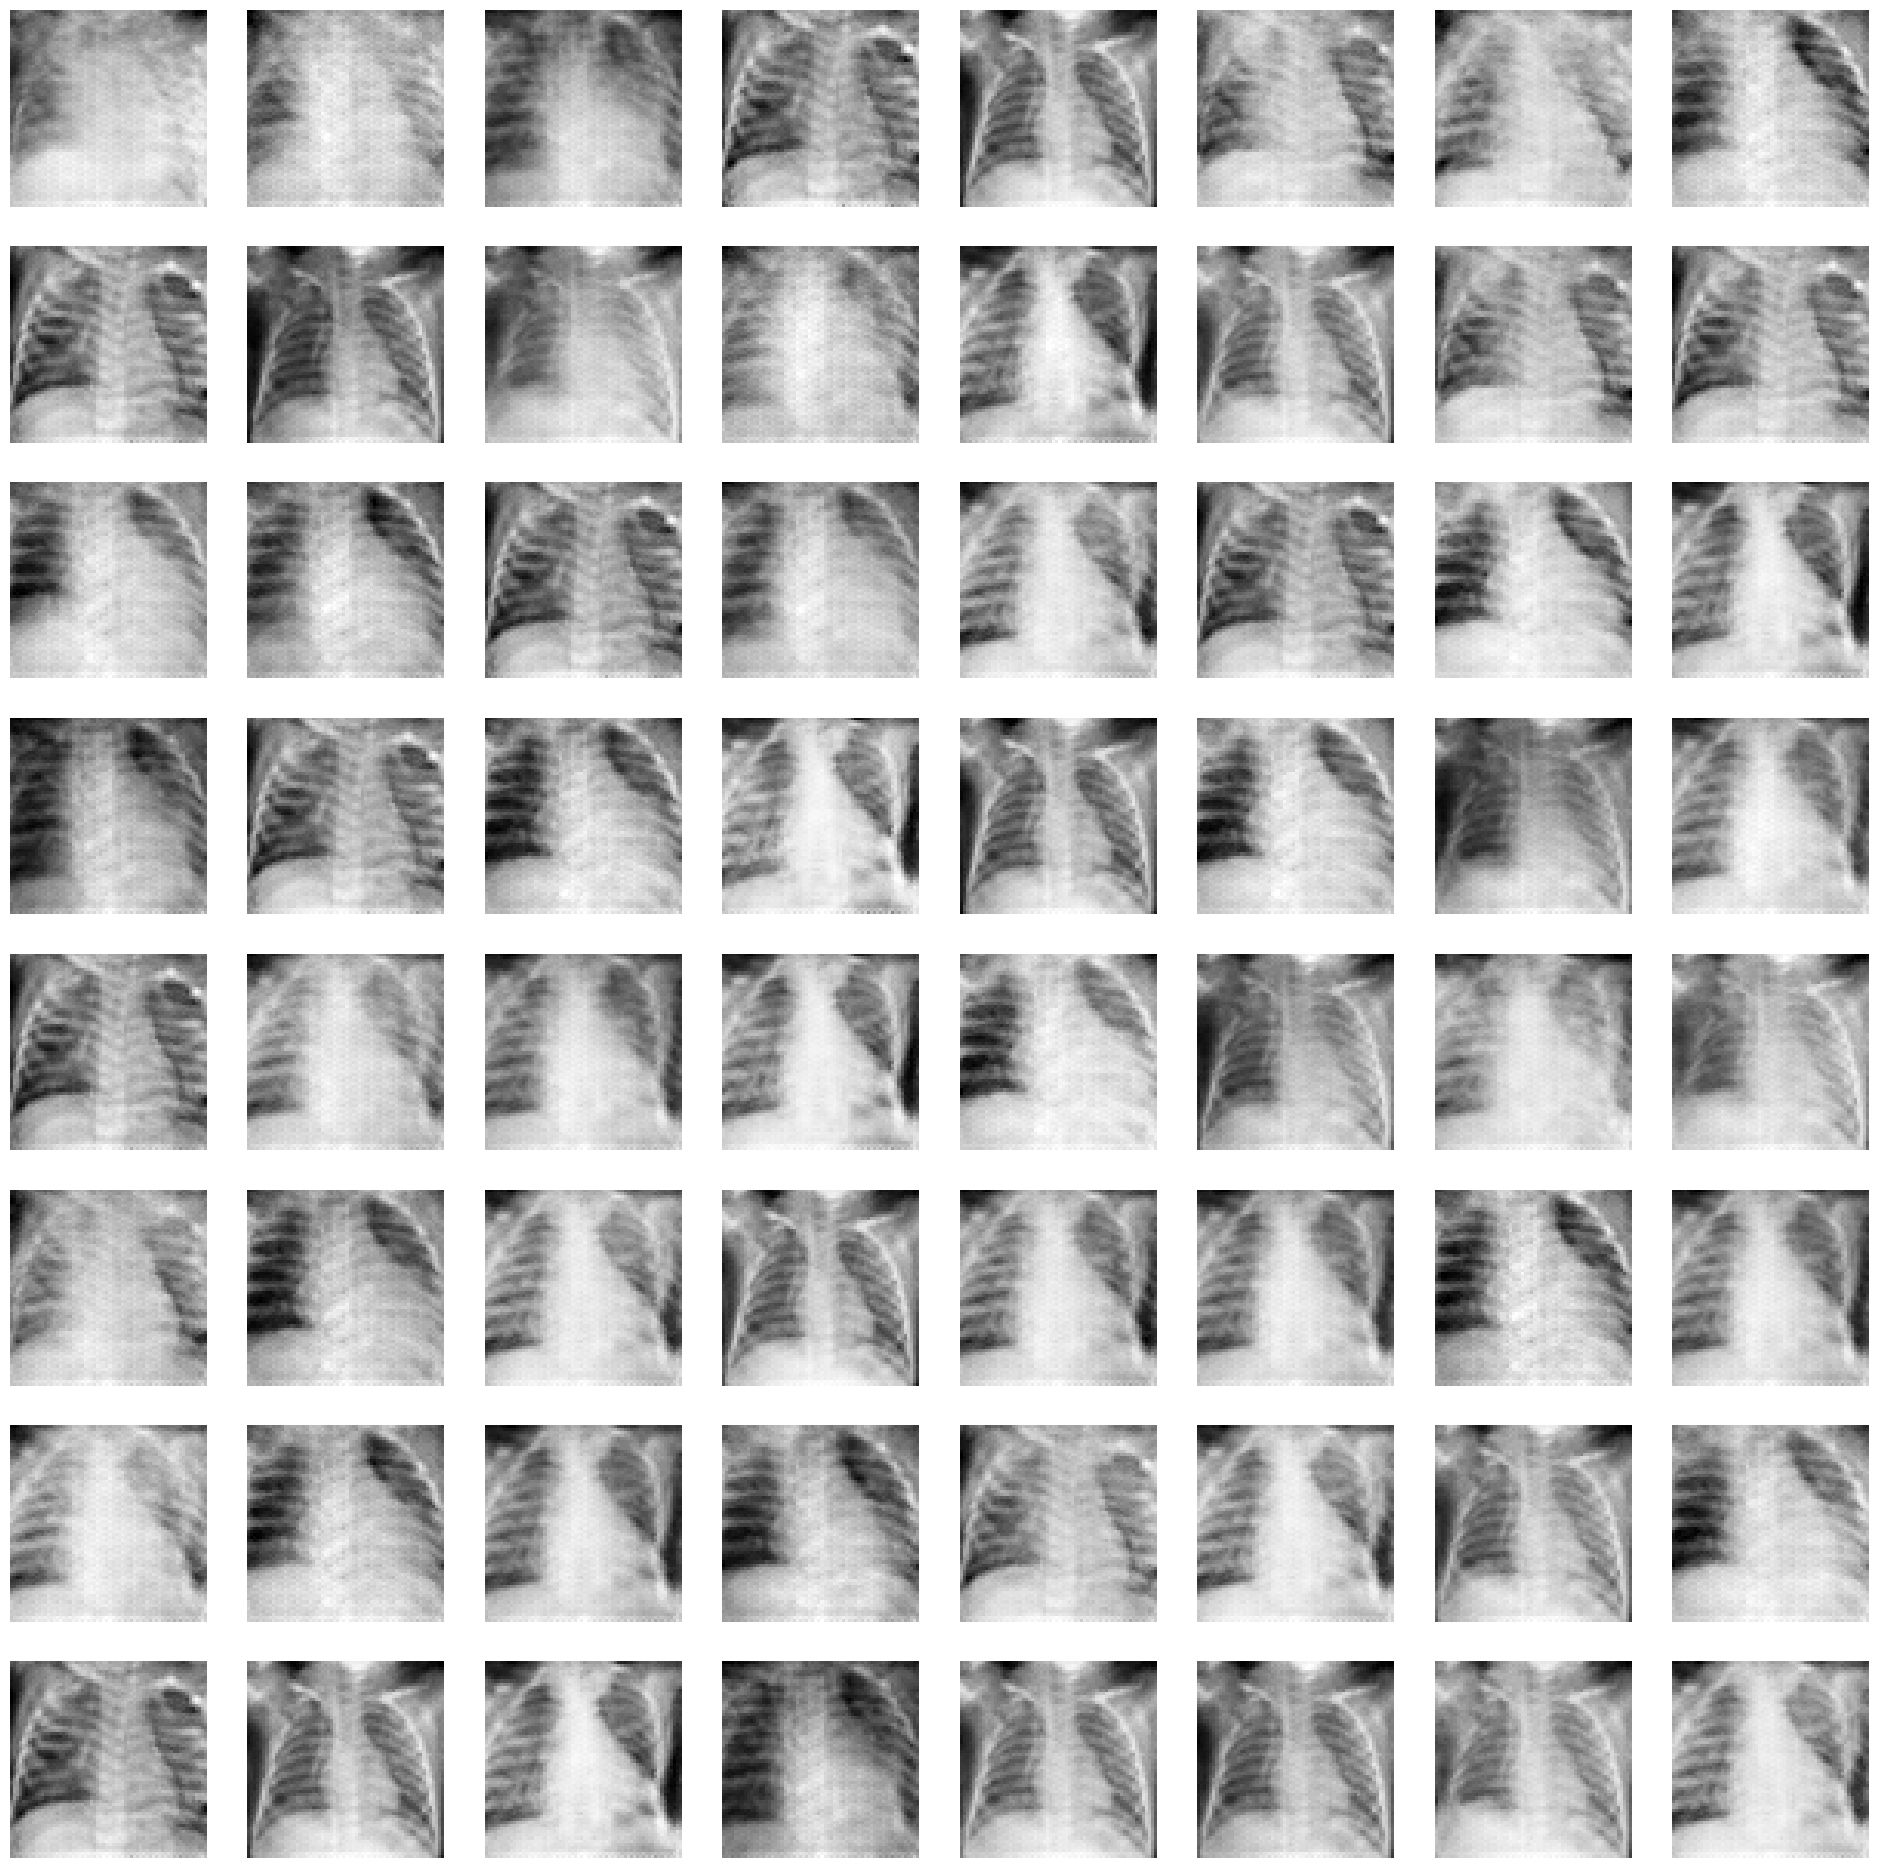

In [76]:
img = netG(fixed_noise)
img_array = []

for image in img:
    img_array.append(image[0].reshape(64,64).detach().cpu())

transform = T.ToPILImage()
counter = 0
for img in img_array:
    output = transform(img.squeeze())
    output.save(os.path.join(sys.path[0], f"output_data/COMBINED/img{counter}.jpeg"))
    counter += 1

nrows, ncols = (8, 8)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

counter = 0
for row in range(nrows):
    for col in range(ncols):
        axes[row, col].imshow(img_array[counter].squeeze(), cmap='gray')
        axes[row, col].axis('off')
        counter += 1


In [72]:
!python -m pytorch_fid output_data/COMBINED image_data/cleaned_test/NORMAL

FID:  228.47309042240647



100%|██████████| 2/2 [00:07<00:00,  3.98s/it]

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


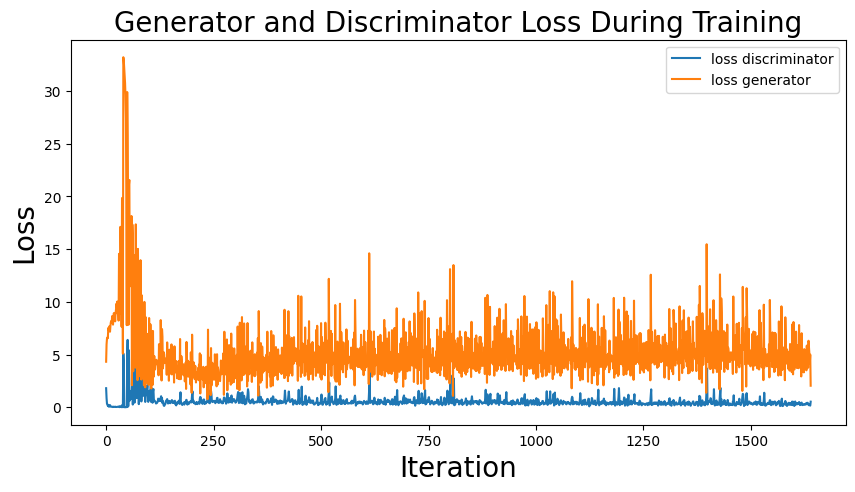

In [75]:
#Taken from DC GAN KERAS
def plot_loss(loss_d, loss_g):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss_d, label="loss discriminator") 
    plt.plot(loss_g, label="loss generator") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss_d = np.load("loss_D_arr.npy", allow_pickle= True)
loss_g = np.load("loss_G_arr.npy", allow_pickle= True)
plot_loss(loss_d, loss_g)